In [1]:
import torch
import torchvision
from torch.nn import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models, transforms
import cv2

In [2]:
!git clone https://github.com/yiskw713/ScoreCAM.git

Cloning into 'ScoreCAM'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 25 (delta 2), reused 20 (delta 0), pack-reused 0
Unpacking objects: 100% (25/25), 3.29 MiB | 4.98 MiB/s, done.


In [3]:
import sys
sys.path.append('/content/ScoreCAM')

In [4]:
%matplotlib inline

import skimage.transform
import torch.nn as nn
from ScoreCAM import cam

from matplotlib.pyplot import imshow
from torchvision.utils import save_image

from cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp, ScoreCAM
from utils.visualize import visualize, reverse_normalize
from utils.imagenet_labels import label2idx, idx2label

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


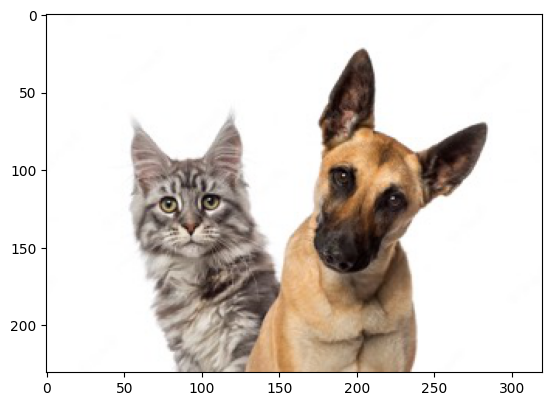

In [6]:
#Loading the original image

image_path = '/content/drive/MyDrive/Deep Learning Projects/Fooling attribution techniques/dog_cat_3.jpeg'
imshow(Image.open(image_path))
image = cv2.imread(image_path)

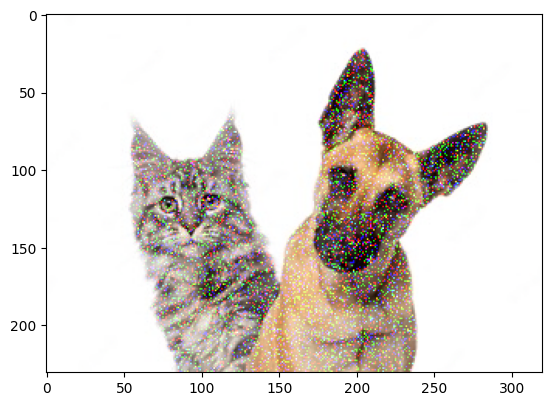

In [7]:
#Adding noise to the original image

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mean = 0
variance = 0.7
stddev = variance ** 0.5
noise = np.random.normal(mean, stddev, image.shape).astype(np.uint8)
image = cv2.add(image, noise)

imshow(image)

In [8]:
# preprocessing the test image

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

In [9]:
# converting image to tensor

tensor = preprocess(image)

# reshape 4D tensor (N, C, H, W); N:batch size, C: Channels, H: Height of tensor, W: Width of tensor

tensor = tensor.unsqueeze(0)

#Lets check the tensor shape
tensor.shape

torch.Size([1, 3, 231, 320])

In [10]:
# Using a pretrained model for image classification

model = models.resnet18(pretrained=True)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 318MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
# the target layer you want to visualize

target_layer = model.layer4[1].conv2
print(target_layer)

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [12]:
# Using the SmoothGradCAM logic to build the saliency map

wrapped_model = SmoothGradCAMpp(model, target_layer, n_samples=25, stdev_spread=0.15)

In [13]:
cam, idx = wrapped_model(tensor)
print(idx2label[idx])

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


predicted class ids 285	 probability 0.24401479959487915
Egyptian cat


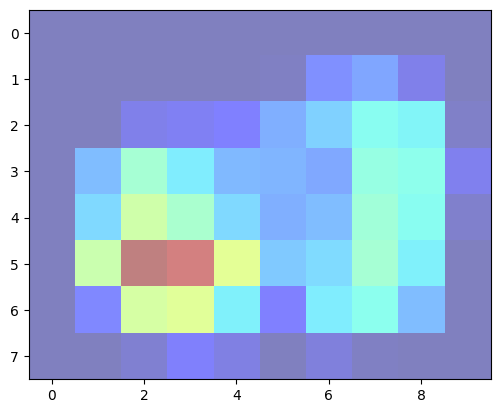

In [14]:
# visualize only cam
imshow(cam.squeeze().numpy(), alpha=0.5, cmap='jet')

In [15]:
# reverse normalization for display
img = reverse_normalize(tensor)

In [16]:
heatmap = visualize(img, cam)

In [17]:
# save image
save_image(heatmap, '/content/{}.png'.format(idx2label[idx]))

In [18]:
# wrapped_model = CAM(model, target_layer)
# wrapped_model = GradCAM(model, target_layer)
# wrapped_model = GradCAMpp(model, target_layer)
# wrapped_model = ScoreCAM(model, target_layer)